In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
from torch.utils.data import DataLoader, random_split, Subset,Dataset
import matplotlib
import cv2
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os
from PIL import Image
import random
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
import PIL
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.optim.lr_scheduler import StepLR

In [2]:
path = '/kaggle/input/amia-public-challenge-2024/train/train/'
csv_path = '/kaggle/input/amia-public-challenge-2024/train.csv'
image_size_path = '/kaggle/input/amia-public-challenge-2024/img_size.csv'
new_size = (1024, 1024)

## Loading the Dataset and Preprocessing

In [3]:
data_o = pd.read_csv(csv_path) #Dataframe with all the available information
image_sizes_df = pd.read_csv(image_size_path) #Dataframe that holds the original sizes of the images

In [4]:
def average_boxes(df):
    """
    Average bounding boxes for each group of image_id and class_id.

    Parameters:
    - df (DataFrame): DataFrame containing bounding boxes for different classes.

    Returns:
    - DataFrame with averaged bounding box coordinates.
    """
    # Group by image_id and class_id
    grouped = df.groupby(['image_id', 'class_id'])

    # Define function to calculate average bounding boxes
    def calculate_averages(group):
        x_min_avg = group['x_min'].mean()
        y_min_avg = group['y_min'].mean()
        x_max_avg = group['x_max'].mean()
        y_max_avg = group['y_max'].mean()
        return pd.Series({
            'x_min': round(x_min_avg, 2),
            'y_min': round(y_min_avg, 2),
            'x_max': round(x_max_avg, 2),
            'y_max': round(y_max_avg, 2)
        })

    # Apply the averaging function
    averaged_df = grouped.apply(calculate_averages, include_groups=False).reset_index()
    
    # Merge with the original DataFrame to keep additional columns
    result_df = pd.merge(df[['image_id', 'class_id', 'class_name']].drop_duplicates(), averaged_df, on=['image_id', 'class_id'])
    
    return result_df

In [5]:
averaged_df = average_boxes(data_o)
print(averaged_df)

                               image_id  class_id          class_name   x_min  \
0      bM8C97htulC9fHKIDurJHquCXr1KZuug        14          No finding     NaN   
1      0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m         0  Aortic enlargement  1169.0   
2      Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w         4       Consolidation   264.0   
3      vqw6mWifHgCf8jmTotrMAS3qCk5eJuc4        14          No finding     NaN   
4      EzfCkMwi4E5bAtZZo4brqt9dNbm7sF9z        14          No finding     NaN   
...                                 ...       ...                 ...     ...   
17898  CdQTR8TktHNjigilD7NfN3wd3gMjSP67         6        Infiltration  1365.0   
17899  GaYTbGReD23PmqVGquBZuCldNgxI1chG         9        Other lesion  1361.0   
17900  8RQmdJy5QggUaFfskOKmv0MAA6qwaU1B         0  Aortic enlargement  1147.0   
17901  VB9qIgH0NlPf97mkeDOWPZPWrrTeXCOP         3        Cardiomegaly  1075.0   
17902  wQtrKg6nlN2wadrVTWXn5WYe1TsB38pB        13  Pulmonary fibrosis   841.0   

         y_min    x_max    

In [6]:
#Including the original dimentions of the images in the dataframe
merged_df = averaged_df.merge(image_sizes_df, on='image_id') 

In [7]:
merged_df

,image_id,class_id,class_name,x_min,y_min,x_max,y_max,dim0,dim1
0,bM8C97htulC9fHKIDurJHquCXr1KZuug,14,No finding,NaN,NaN,NaN,NaN,2430,1994
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,0,Aortic enlargement,1169.0,510.33,1462.33,829.67,2154,2402
2,Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w,4,Consolidation,264.0,732.00,550.00,1119.00,2464,2072
3,vqw6mWifHgCf8jmTotrMAS3qCk5eJuc4,14,No finding,NaN,NaN,NaN,NaN,3072,3072
4,EzfCkMwi4E5bAtZZo4brqt9dNbm7sF9z,14,No finding,NaN,NaN,NaN,NaN,2659,2337
...,...,...,...,...,...,...,...,...,...
17898,CdQTR8TktHNjigilD7NfN3wd3gMjSP67,6,Infiltration,1365.0,1304.00,1772.00,1646.00,2232,2072
17899,GaYTbGReD23PmqVGquBZuCldNgxI1chG,9,Other lesion,1361.0,281.00,1598.00,728.00,3072,3072
17900,8RQmdJy5QggUaFfskOKmv0MAA6qwaU1B,0,Aortic enlargement,1147.0,805.00,1348.00,1033.00,2880,2304
17901,VB9qIgH0NlPf97mkeDOWPZPWrrTeXCOP,3,Cardiomegaly,1075.0,1626.00,1949.00,1858.00,2880,2304


In [8]:
#Replacing NaN values with 0
merged_df['x_min'],merged_df['y_min'] = merged_df['x_min'].fillna(0),merged_df['y_min'].fillna(0)
merged_df['x_max'],merged_df['y_max'] = merged_df['x_max'].fillna(0),merged_df['y_max'].fillna(0)

In [9]:
def scale_boxes(boxes, original_size, new_size):
    
    """
    Scale boxes for each group of image_id and class_id.

    Parameters:
    - boxes : Array of coordinates of bounding boxes.
    - original_size : Array containing original image sizes.
    - new_size : Array containing the resized dimensions of the images.

    Returns:
    - DataFrame with scaled bounding box coordinates.
    """
    
    scale_x = new_size[0] / original_size[0]
    scale_y = new_size[1] / original_size[1]
    #If class is no fininding the boxes should be [0,0,1,1]
    scaled_boxes = [
        [round(x_min * scale_x, 2), round(y_min * scale_y, 2), 
         1 if x_max==0 else round(x_max * scale_x, 2), 1 if y_max==0 else round(y_max * scale_y, 2)]
        for x_min, y_min, x_max, y_max in boxes
    ]
    return scaled_boxes

In [10]:
def adjust_bounding_boxes(df, new_size):
    """
    Adjusting bounidng boxes with respect to the resized image dimensions.

    Parameters:
    - df : DataFrame containing bounding boxes for different classes.
    - new_size : Array containing the resized dimensions of the images.

    Returns:
    - DataFrame with adjusted bounding box coordinates.
    """
    adjusted_boxes = []
    for _, row in df.iterrows():
        original_size = (row['dim1'], row['dim0'])
        boxes = [[row['x_min'], row['y_min'], row['x_max'], row['y_max']]]
        scaled_boxes = scale_boxes(boxes, original_size, new_size)
        adjusted_boxes.append(scaled_boxes[0])  # Append the scaled bounding boxes
    df['scaled_boxes'] = adjusted_boxes

In [11]:
adjust_bounding_boxes(merged_df, new_size)

In [12]:
merged_df

,image_id,class_id,class_name,x_min,y_min,x_max,y_max,dim0,dim1,scaled_boxes
0,bM8C97htulC9fHKIDurJHquCXr1KZuug,14,No finding,0.0,0.00,0.00,0.00,2430,1994,"[0.0, 0.0, 1, 1]"
1,0FDQVdLgDKI1sRnPL94LzVh9EvXDVM9m,0,Aortic enlargement,1169.0,510.33,1462.33,829.67,2154,2402,"[498.36, 242.61, 623.41, 394.42]"
2,Dwk2TnGJFaMhyi3OfCrhdZG9ppGglC5w,4,Consolidation,264.0,732.00,550.00,1119.00,2464,2072,"[130.47, 304.21, 271.81, 465.04]"
3,vqw6mWifHgCf8jmTotrMAS3qCk5eJuc4,14,No finding,0.0,0.00,0.00,0.00,3072,3072,"[0.0, 0.0, 1, 1]"
4,EzfCkMwi4E5bAtZZo4brqt9dNbm7sF9z,14,No finding,0.0,0.00,0.00,0.00,2659,2337,"[0.0, 0.0, 1, 1]"
...,...,...,...,...,...,...,...,...,...,...
17898,CdQTR8TktHNjigilD7NfN3wd3gMjSP67,6,Infiltration,1365.0,1304.00,1772.00,1646.00,2232,2072,"[674.59, 598.25, 875.74, 755.15]"
17899,GaYTbGReD23PmqVGquBZuCldNgxI1chG,9,Other lesion,1361.0,281.00,1598.00,728.00,3072,3072,"[453.67, 93.67, 532.67, 242.67]"
17900,8RQmdJy5QggUaFfskOKmv0MAA6qwaU1B,0,Aortic enlargement,1147.0,805.00,1348.00,1033.00,2880,2304,"[509.78, 286.22, 599.11, 367.29]"
17901,VB9qIgH0NlPf97mkeDOWPZPWrrTeXCOP,3,Cardiomegaly,1075.0,1626.00,1949.00,1858.00,2880,2304,"[477.78, 578.13, 866.22, 660.62]"


In [13]:
CLASS_ID_NAMES = merged_df[['class_id', 'class_name']].drop_duplicates().set_index('class_id')['class_name'].to_dict()

In [14]:
CLASS_ID_NAMES

{14: 'No finding',
 0: 'Aortic enlargement',
 4: 'Consolidation',
 8: 'Nodule/Mass',
 3: 'Cardiomegaly',
 7: 'Lung Opacity',
 13: 'Pulmonary fibrosis',
 12: 'Pneumothorax',
 11: 'Pleural thickening',
 2: 'Calcification',
 1: 'Atelectasis',
 10: 'Pleural effusion',
 5: 'ILD',
 6: 'Infiltration',
 9: 'Other lesion'}

## Creating Training and Test Data

In [18]:
#Transforms applied on the images to load
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure image is grayscale
    transforms.ToTensor(),                        # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1]
])

In [19]:
#Custom dataset class to trasform and group images with corresponding classes and boxes
class CustomDataset(Dataset):
    def __init__(self, dataframe, img_dir , transform=None):
        self.img_ids = dataframe['image_id'].unique()
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,self.img_ids[idx]+'.png')
        image = Image.open(img_name).convert('L')
        
        records = self.dataframe[self.dataframe['image_id']==self.img_ids[idx]]
        
        labels = np.array(records['class_id'],dtype=np.int64)
        bbox = records['scaled_boxes'].to_list()
        
        
        if self.transform:
            image = self.transform(image)
            
        target = {
            'boxes': torch.tensor(bbox),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

        
        return image, target

In [20]:
dataset = CustomDataset(merged_df, path,transform=transform)

In [21]:
torch.manual_seed(42)
total_size = len(dataset)

train_size = int(0.9 * total_size)
test_size = total_size - train_size

# Split the dataset
train_dataset,test_dataset = random_split(dataset, [train_size,test_size])

In [22]:
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, list(targets)

In [23]:
train_loader = DataLoader(
    train_dataset,
    batch_size=3,
    sampler=SubsetRandomSampler(range(len(train_dataset))),
    collate_fn=collate_fn,
    num_workers=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=3,
    sampler=SubsetRandomSampler(range(len(test_dataset))),
    collate_fn=collate_fn,
    num_workers=4
)

## Visualising the data

In [24]:
def plot_images_with_boxes(images, targets, class_names):
    """
    Plot images with bounding boxes and labels.

    Parameters:
    - images: tensors, each representing an image.
    - targets: dictionaries, each containing 'boxes', and 'labels'.
    - class_names: Dictionary mapping class indices to class names.
    """

    image = images.squeeze(0)  # Remove channel dimension if grayscale
    image = (image + 1) / 2  # Reverse normalization if necessary

    # Convert image to numpy format for plotting
    image_np = image.cpu().numpy()

    # Plot image
    fig, ax = plt.subplots(1)
    ax.imshow(image_np, cmap='gray')

    # Get predictions for the current image
    boxes = targets['boxes']
    labels = targets['labels']

    # Plot each bounding box
    for box_idx in range(len(boxes)):
        box = boxes[box_idx].cpu().detach().numpy()
        label = labels[box_idx].item()

        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin

        # Create a rectangle patch
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add label and score
        label_name = class_names.get(label, "Unknown")
        ax.text(xmin, ymin - 10, f'{label_name}', bbox=dict(facecolor='r', alpha=0.5), fontsize=8, color='white')

    plt.show()

In [25]:
images, targets = train_dataset[2]
images1, targets1 = train_dataset[20]

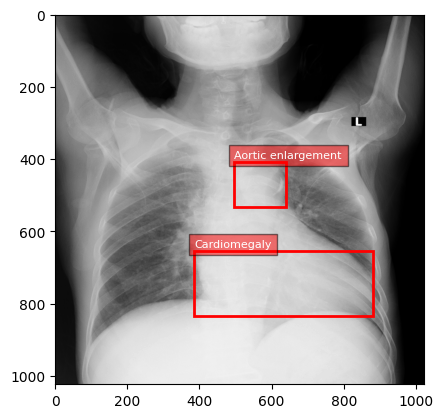

In [26]:
plot_images_with_boxes(images, targets, CLASS_ID_NAMES)

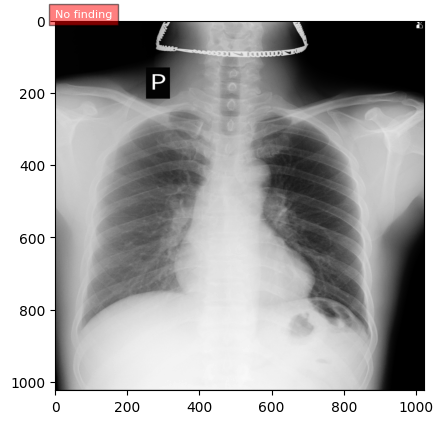

In [27]:
plot_images_with_boxes(images1, targets1, CLASS_ID_NAMES)

## Loading the Pretrained FasterRCNN ResNet 50 Model

In [28]:
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 173MB/s]  


In [29]:
# Modify classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 15  
#model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.roi_heads.box_predictor.cls_score = torch.nn.Linear(
            in_features=in_features, out_features=num_classes, bias=True
        )
model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(
            in_features=in_features, out_features=num_classes*4, bias=True
        )

# Move model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [30]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.7) 
num_epochs=5
epoch_losses = []

## Training the model with the new data

In [31]:
model.train() # Set the model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # Forward pass
            loss_dict = model(images, targets)
            
            # Calculate total loss
            losses = sum(loss for loss in loss_dict.values())

            # Zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            running_loss += losses.item()
            
            pbar.set_postfix(loss=losses.item())
            pbar.update(1)

        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


    # Step the scheduler
    scheduler.step()

Epoch 1/5: 100%|██████████| 2572/2572 [14:05<00:00,  3.04it/s, loss=0.19]  


Epoch 1/5, Loss: 0.2602


Epoch 2/5: 100%|██████████| 2572/2572 [14:03<00:00,  3.05it/s, loss=0.056] 


Epoch 2/5, Loss: 0.2286


Epoch 3/5: 100%|██████████| 2572/2572 [14:02<00:00,  3.05it/s, loss=0.0707]


Epoch 3/5, Loss: 0.2198


Epoch 4/5: 100%|██████████| 2572/2572 [14:02<00:00,  3.05it/s, loss=0.209] 


Epoch 4/5, Loss: 0.2107


Epoch 5/5: 100%|██████████| 2572/2572 [14:03<00:00,  3.05it/s, loss=0.376] 

Epoch 5/5, Loss: 0.2047


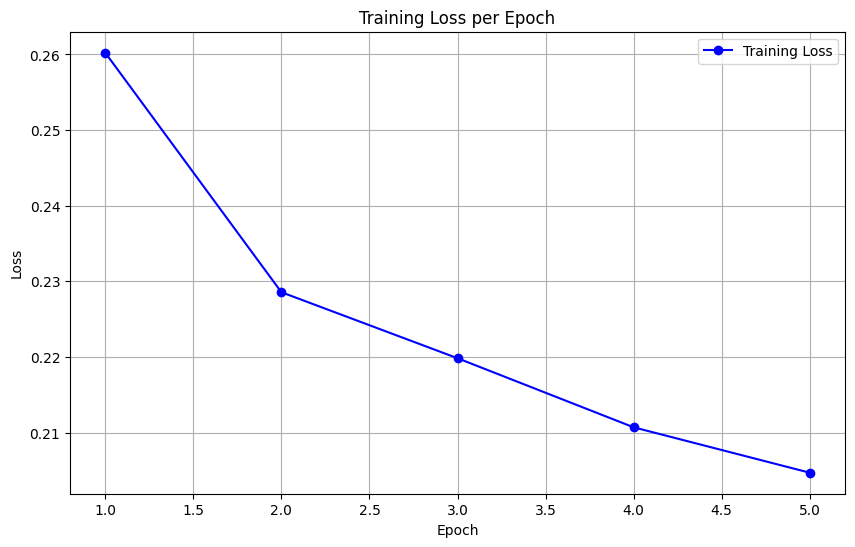

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
#save the model to the disk
torch.save(model.state_dict(), 'ObjectDetection.pth')

In [116]:
model.load_state_dict(torch.load('/kaggle/working/ObjectDetection.pth', map_location=device))

<All keys matched successfully>

## Testing the Model

In [41]:
model.eval()
all_preds = []
all_targets = []
i=0
with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Testing the model") as pbar:
        while i<len(test_loader):
            inputs, targets = next(iter(test_loader))
            #images = list(image.to(device) for image in images)
            #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(inputs.to(device))

            filtered_predictions = []
            for prediction in outputs:
                scores = prediction['scores']
                mask = scores > 0.4

                # Apply mask to boxes, labels, and scores
                filtered_boxes = prediction['boxes'][mask]
                filtered_labels = prediction['labels'][mask]
                filtered_scores = prediction['scores'][mask]

                # Add to the list of filtered predictions
                filtered_predictions.append({
                    'boxes': filtered_boxes,
                    'labels': filtered_labels,
                    'scores': filtered_scores
                })

            all_preds.append(filtered_predictions)
            all_targets.append(targets)
            i+=1
            
            pbar.update(1)

Testing the model: 100%|██████████| 286/286 [02:51<00:00,  1.67it/s]


In [69]:
#Check how many correct labels were predicted
def calculate_accuracy(all_preds,all_targets):
    count=0
    tot=0
    for idx,i in enumerate(all_preds):
        for jdx,j in enumerate(i):
            pred_l = (j['labels'].unique()).cpu().numpy()
            act_l = (all_targets[idx][jdx]['labels'].to(device)).cpu().numpy()

            if len(pred_l)==len(act_l):
                if (pred_l==act_l).any():
                    count+=(pred_l == act_l).sum()
            tot+=1
    return (count/tot * 100)


In [70]:
print("Test Accuracy with respect to labels : ", calculate_accuracy(all_preds,all_targets))

Test Accuracy with respect to labels :  53.613053613053616


In [117]:
def plot_predictions(images, preds, class_names, targets):
    """
    Plot images with bounding boxes and labels.

    Parameters:
    - images: List of tensors, each representing an image.
    - preds: List of dictionaries, each containing 'boxes', 'labels', and 'scores'.
    - class_names: Dictionary mapping class indices to class names.
    """

    num_images = len(images)
    
    for img_idx in range(num_images):
        image = images[img_idx].squeeze(0)  # Remove channel dimension if grayscale
        image = (image + 1) / 2  # Reverse normalization if necessary

        # Convert image to numpy format for plotting
        image_np = image.cpu().numpy()
        
        # Plot image
        fig, ax = plt.subplots(1)
        ax.imshow(image_np, cmap='gray')
        
        # Get predictions for the current image
        boxes = preds[img_idx]['boxes']
        labels = preds[img_idx]['labels']
        scores = preds[img_idx]['scores']
        true_label = targets[img_idx]['labels']
        ax.text(0.1,0.9,s=true_label,ha='right',va='top')
        
        
        # Plot each bounding box
        for box_idx in range(len(boxes)):
            box = boxes[box_idx].cpu().detach().numpy()
            label = labels[box_idx].item()
            score = scores[box_idx].item()
            
            xmin, ymin, xmax, ymax = box
            width, height = xmax - xmin, ymax - ymin
            
            # Create a rectangle patch
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            # Add label and score
            label_name = class_names.get(label, "Unknown")
            ax.text(xmin, ymin - 10, f'{label_name} {label} ({score:.2f})', bbox=dict(facecolor='r', alpha=0.5), fontsize=8, color='white')
            
        plt.show()

In [122]:
inputs, targets = next(iter(test_loader))

In [123]:
predictions = model(inputs.to(device))

In [124]:
filtered_predictions = []
for prediction in predictions:
    scores = prediction['scores']
    mask = scores > 0.4

    # Apply mask to boxes, labels, and scores
    filtered_boxes = prediction['boxes'][mask]
    filtered_labels = prediction['labels'][mask]
    filtered_scores = prediction['scores'][mask]

    # Add to the list of filtered predictions
    filtered_predictions.append({
        'boxes': filtered_boxes,
        'labels': filtered_labels,
        'scores': filtered_scores
    })

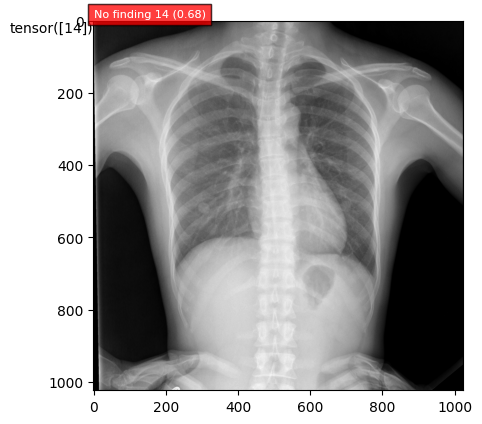

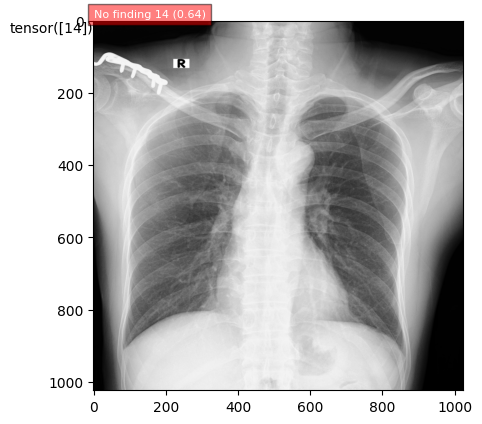

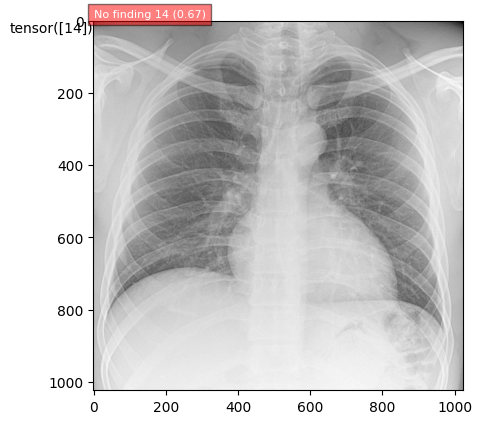

In [125]:
plot_predictions(inputs, filtered_predictions, CLASS_ID_NAMES, targets)